## <a id='toc1_1_'></a>[Reproduction of the UniformatBridge model implementation](#toc0_)

- This is an **_unofficial_** reproduction of the experiment described in "Transformer language model for mapping construction schedule activities to uniformat categories" by Yoonhwa Jung, Julia Hockenmaier, and Mani Golparvar-Fard, 2024.
- The study can be accessed at https://doi.org/10.1016/j.autcon.2023.105183.

**Table of contents**<a id='toc0_'></a>    
- [Reproduction of the UniformatBridge model implementation](#toc1_1_)    
    - [Data](#toc1_1_1_)    
      - [BIM and ASTM Uniformat categories](#toc1_1_1_1_)    
      - [★ Additional Experiment: What if we simply duplicate scarce data for data balancing?](#toc1_1_1_2_)    
      - [Label Encoding](#toc1_1_1_3_)    
      - [Text Encoding](#toc1_1_1_4_)    
      - [Make DataLoader](#toc1_1_1_5_)    
      - [★ Additional Datasets: ASTM Uniformat II Classification for Building Elements Description](#toc1_1_1_6_)    
      - [★ Additional Datasets: Data augmentation with GPT-2](#toc1_1_1_7_)    
      - [★ New Train DataLoader for Fine-tuning with ASTM Uniformat Class Definition Data](#toc1_1_1_8_)    
    - [Fine-tuning (Train & Validation)](#toc1_1_2_)    
    - [Test](#toc1_1_3_)    
    - [Experimental Results](#toc1_1_4_)    
      - [Overall Results](#toc1_1_4_1_)    
      - [Class-wise Results](#toc1_1_4_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import time; start_time = time.time()

In [2]:
!python -V

Python 3.11.6


In [3]:
# Experimental Settings from Jung et al. (2024)
# 6p: "Five epochs with a batch size of 32, a dropout rate of 0.1, and a learning rate of 1.5e−5 were used to fine-tune the model."
epoch_size = 5
batch_size = 32
dropout_rate = 0.1  # BertForSequenceClassification default dropout_rate = 0.1
learning_rate = 1.5e-5

# 7p: "In Table 2 and 3, 𝜇 is the average performance on three random seeds, and 𝜎 is their standard deviation."
rseed = 42

In [4]:
experiment_name = 'gpt2_balancing'  # for writing output file names.

experiment_setting = {
    'rseed': rseed, 
    'simple_balancing': False, # 'True' takes long time to train
    'gpt2_balancing': False,
}

import json
with open(f'experimental_results/{experiment_name}_experiment_setting.json', 'w') as json_file:
    json.dump(experiment_setting, json_file, indent=4, sort_keys=True)

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### <a id='toc1_1_1_'></a>[Data](#toc0_)

#### <a id='toc1_1_1_1_'></a>[BIM and ASTM Uniformat categories](#toc0_)

In [6]:
import pandas as pd
dataset_path = "E:/_datasets/jung_et_al_2024/"  # Data should not be shared publicly.
df = pd.read_excel(dataset_path+"0-overall-level3.xlsx", header=0)

cls = 'Level3'
df = df.loc[:, ['predwbs2', 'predwbs', 'predtask', 'wbs2', 'wbs', 'name', 'sucwbs2', 'sucwbs', 'suctask', cls]]

In [7]:
new_tokens = ['[pred]', '[succ]']

df['text'] = df.apply(
    lambda row: f"{row['predwbs2']} > {row['predwbs']} > {row['predtask']} [pred] {row['wbs2']} > {row['wbs']} > {row['name']} [succ] {row['sucwbs2']} > {row['sucwbs']} > {row['suctask']}",
    axis=1
)
df['label'] = df[cls]
label_cnt = df['label'].value_counts()

print_idx = 6538  # D2040: 'Rain Water Drainage' case in Table 4
print('text: ', df['text'][print_idx])
print('label: ', df['label'][print_idx])

text:  CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mechanical Equipment [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Pipe Mechanical Equipment [succ]  100 KINGSHIGHWAY > COMMISSIONNG & INSPECTIONS > STARTUP
label:  D2040


In [8]:
from sklearn.model_selection import train_test_split

texts = df['text']
labels = df['label']

# 6p: "This dataset is further split into training, validation, and testing using a 60-20-20 distribution."
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.4, random_state=rseed)
validation_texts, test_texts, validation_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=rseed)

(len(train_texts), len(validation_texts), len(test_texts))

(20469, 6823, 6824)

#### <a id='toc1_1_1_2_'></a>[★ Additional Experiment: What if we simply duplicate scarce data for data balancing?](#toc0_)

In [9]:
if experiment_setting['simple_balancing']:
    label_counts = train_labels.value_counts()

    # Set the frequency of the most frequent label as the target for all labels
    max_count = label_counts.max()

    train_texts_balanced = []
    train_labels_balanced = []
    for label, count in label_counts.items():
        # Calculate how many times to duplicate based on the target frequency
        factor = max_count // count
        remainder = max_count % count
        
        # Select texts corresponding to the current label
        texts_of_label = train_texts[train_labels == label]
        
        # Duplicate texts to match the target frequency
        for _ in range(factor):
            train_texts_balanced.extend(texts_of_label)
            train_labels_balanced.extend([label] * len(texts_of_label))
        
        if remainder > 0:
            train_texts_balanced.extend(texts_of_label[:remainder])
            train_labels_balanced.extend([label] * remainder)

    train_texts = pd.Series(train_texts_balanced)
    train_labels = pd.Series(train_labels_balanced)

    # Data should not be shared publicly.
    pd.DataFrame({'text': train_texts, 'label': train_labels}).to_csv(dataset_path+f"/train_data_balanced_{experiment_name}.csv", index=False)
    print(train_labels.value_counts().head())

#### <a id='toc1_1_1_3_'></a>[Label Encoding](#toc0_)

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(labels)

train_labels_encoded = label_encoder.transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
test_labels_encoded = label_encoder.transform(test_labels)

#### <a id='toc1_1_1_4_'></a>[Text Encoding](#toc0_)

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_)).to(device)

tokenizer.add_tokens(new_tokens)
model.resize_token_embeddings(len(tokenizer))

tokenizer, model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	30522: AddedToken("[pred]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
 	30523: AddedTo

#### <a id='toc1_1_1_5_'></a>[Make DataLoader](#toc0_)

In [12]:
from torch.utils.data import TensorDataset, DataLoader

def make_dataloader(plain_texts, encoded_labels, batch_size=32):
    '''
    plain_texts: list of strings (should be encoded when making dataloader due to tokenizer padding/truncation)
    encoded_labels: list of class indices (should be encoded beforehand using LabelEncoder with the entire dataset)
    '''
    texts = tokenizer(plain_texts, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)
    labels = torch.tensor(encoded_labels, dtype=torch.long).to(device)
    dataset = TensorDataset(
        texts['input_ids'], 
        texts['attention_mask'], 
        labels,
    )
    return DataLoader(dataset, batch_size=batch_size)

train_loader = make_dataloader(train_texts.tolist(), train_labels_encoded, batch_size)
validation_loader = make_dataloader(validation_texts.tolist(), validation_labels_encoded, batch_size)
test_loader = make_dataloader(test_texts.tolist(), test_labels_encoded, batch_size)

len(train_loader), len(validation_loader), len(test_loader)

(640, 214, 214)

#### <a id='toc1_1_1_6_'></a>[★ Additional Datasets: ASTM Uniformat II Classification for Building Elements Description](#toc0_)

In [13]:
import pandas as pd

# Publicly available definition of ASTM Uniformat II
# https://www.govinfo.gov/content/pkg/GOVPUB-C13-5af96252bc88826c911daac93c449927/pdf/GOVPUB-C13-5af96252bc88826c911daac93c449927.pdf
df_astm = pd.read_csv("public_astm_uniformat_ii_classification.csv", header=0)

df_astm = df_astm[df_astm['Class'].isin(label_encoder.classes_)] # Use only the classes that are in the dataset
df_astm

,Level1,Level2,Level3,Class
0,SUBSTRUCTURE,Foundations,Standard Foundations,A1010
1,SUBSTRUCTURE,Foundations,Special Foundations,A1020
2,SUBSTRUCTURE,Foundations,Slab on Grade,A1030
3,SHELL,Superstructure,Floor Construction,B1010
4,SHELL,Superstructure,Roof Construction,B1020
5,SHELL,Exterior Enclosure,Exterior Walls,B2010
6,SHELL,Exterior Enclosure,Exterior Windows,B2020
7,SHELL,Exterior Enclosure,Exterior Doors,B2030
8,SHELL,Roofing,Roof Coverings,B3010
9,SHELL,Roofing,Roof Openings,B3020


#### <a id='toc1_1_1_7_'></a>[★ Additional Datasets: Data augmentation with GPT-2](#toc0_)

In [14]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, set_seed

set_seed(42)

gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

def generate_sentences_with_gpt2(prompt_text, max_len=100, num_sentences=20):
    inputs = gpt2_tokenizer.encode(prompt_text, return_tensors='pt')
    outputs = gpt2_model.generate(
        inputs, 
        pad_token_id=gpt2_tokenizer.eos_token_id, 
        max_length=max_len, 
        do_sample=True, temperature=0.7, num_return_sequences=num_sentences,
        # repetition_penalty=1.2,
    )
    if len(outputs) == 1: # Deterministic setting
        generated_text = [gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)] * num_sentences
    else:
        generated_text = [gpt2_tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

    return generated_text

generate_sentences_with_gpt2("Once upon a time,", num_sentences=1)

["Once upon a time, the United States was already a strong contender to compete in World Baseball Classic qualifying, and the team was expected to be the World Baseball Classic's best player for the next few years. However, the team's lack of experience could put it in a precarious position.\n\nIn fact, the team's decision to change its name to K-Mart in order to avoid confusion with the name of the new stadium was also a mistake made. The K-Mart name was used only"]

In [15]:
def generate_with_gpt2_for_astm(level1, level2, level3):

    prompt = f"Examples of building structure components for {level1.lower()} of {level2.lower()} and {level3.lower()} are"
    
    sentences = []
    for sentence in generate_sentences_with_gpt2(prompt):
        sentence = sentence[len(prompt):]
        for remove_char in ['\n']: #, '.', '•', '·']:
            sentence = sentence.replace(remove_char, ' ')
        sentence = level1 + " " + level2 + " " + level3 + sentence
        sentences.append(sentence)
    return sentences

generate_with_gpt2_for_astm("SERVICES", "Plumbing", "Rain Water Drainage")  # D2040 in ASTM Uniformat

['SERVICES Plumbing Rain Water Drainage:  1. Water pumps  1.1.1.1.1.1.2. Water pumps are a combination of pumps and pipes which are installed by one entity in a building. The building must use water as a primary source of power, which carries the risk of flooding.  1.1.1.1.2.1.1.1.1.2.1.3',
 'SERVICES Plumbing Rain Water Drainage shown in Figures 1-5. Figure 1. Building structure components for services of water and sewer systems. (a) A concrete structure is shown in Figures 1-3 and Figure 1-4. It is in the form of a concrete structure with a central block with a single, central, and horizontal section. (b) A concrete structure is shown in Figures 1-2 and Figure 1-3. It is in the',
 'SERVICES Plumbing Rain Water Drainage:  The structure will have a wide gap between the two walls, and the roof will be curved up to make it easier to cut through the gaps.  The interior will be made of polyethylene, and the inside will be made of polypropylene.  The roof will be made of a polyethylene mate

#### <a id='toc1_1_1_8_'></a>[★ New Train DataLoader for Fine-tuning with ASTM Uniformat Class Definition Data](#toc0_)

In [16]:
from tqdm import tqdm

gpt2_texts = []
gpt2_labels = []

for _, row in tqdm(df_astm.iterrows(), total=df_astm.shape[0]):
    sentences = generate_with_gpt2_for_astm(row['Level1'], row['Level2'], row['Level3'])
    for sentence in sentences:
        gpt2_texts.append(sentence)
        gpt2_labels.append(row['Class'])

generated_df = pd.DataFrame({'text': gpt2_texts, 'label': gpt2_labels})
generated_df.to_csv(dataset_path+f"/gpt2_data_{experiment_name}.csv", index=False)

48it [03:19,  4.16s/it]


In [17]:
if experiment_setting['gpt2_balancing']:

    import itertools
    train_loader = make_dataloader(
        list(itertools.chain(
            train_texts,
            gpt2_texts,
        )),
        list(itertools.chain(
            train_labels_encoded,
            label_encoder.transform(gpt2_labels),
        )),
        batch_size
    )

len(train_loader)

640

### <a id='toc1_1_2_'></a>[Fine-tuning (Train & Validation)](#toc0_)

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

100%|██████████| 640/640 [02:04<00:00,  5.13it/s]


Epoch 1 | Train Loss: 1.673167624277994 | Validation Loss: 0.5204345054019277


100%|██████████| 640/640 [02:01<00:00,  5.29it/s]


Epoch 2 | Train Loss: 0.3365120352013037 | Validation Loss: 0.20080053935123382


100%|██████████| 640/640 [02:01<00:00,  5.29it/s]


Epoch 3 | Train Loss: 0.14424824210582302 | Validation Loss: 0.12108148562190967


100%|██████████| 640/640 [02:01<00:00,  5.28it/s]


Epoch 4 | Train Loss: 0.08378295502770924 | Validation Loss: 0.08019012748916572


100%|██████████| 640/640 [02:01<00:00,  5.28it/s]


Epoch 5 | Train Loss: 0.05383343415742274 | Validation Loss: 0.06245888402319957


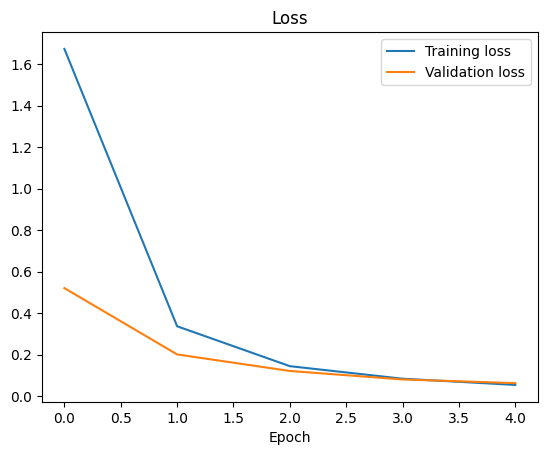

In [19]:
train_losses = []
val_losses = []
for epoch in range(epoch_size):
    model.train()
    train_loss = 0
    for input_ids, attention_mask, labels in tqdm(train_loader):
        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for input_ids, attention_mask, labels in validation_loader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            loss = outputs.loss
            val_loss += loss.item()
    val_losses.append(val_loss / len(validation_loader))
    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]} | Validation Loss: {val_losses[-1]}")

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

### <a id='toc1_1_3_'></a>[Test](#toc0_)

In [20]:
model.eval()
with torch.no_grad():
    true_labels = []
    pred_labels = []
    df_test_rows = []
    for input_ids, attention_mask, labels in test_loader:
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_labels.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        for b in range(input_ids.shape[0]):
            text = tokenizer.decode([token for i, token in enumerate(input_ids[b]) if attention_mask[b][i] == 1])
            pred_label = label_encoder.classes_[torch.argmax(outputs.logits[b]).item()]
            true_label = label_encoder.classes_[labels[b].item()]
            df_test_rows.append({'text': text, 'true_label': true_label, 'pred_label': pred_label, 'correct': pred_label == true_label})

# Data should not be shared publicly.
pd.DataFrame(df_test_rows).to_csv(dataset_path+f"/test_data_pred_results_{experiment_name}.csv")

### <a id='toc1_1_4_'></a>[Experimental Results](#toc0_)

#### <a id='toc1_1_4_1_'></a>[Overall Results](#toc0_)

In [21]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels, 
    pred_labels, 
    # average='weighted', 
    average='macro',  # Original paper setting (page 8)
    zero_division=0
)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.9852
Precision: 0.8892
Recall: 0.8857
F1 Score: 0.8845


#### <a id='toc1_1_4_2_'></a>[Class-wise Results](#toc0_)

In [22]:
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average=None, zero_division=0)

class_names = label_encoder.inverse_transform(list(set(true_labels)))

performance_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})
performance_df.to_csv(f'experimental_results/{experiment_name}_precision_recall_fscore_rseed{rseed}.csv')
performance_df

,Class,Precision,Recall,F1 Score
0,A1010,0.970588,0.985075,0.977778
1,A1020,1.000000,0.967213,0.983333
2,A1030,0.972603,1.000000,0.986111
3,A2010,0.961039,1.000000,0.980132
4,A2020,1.000000,0.846154,0.916667
5,B1010,0.998014,0.998014,0.998014
6,B1020,0.984375,0.961832,0.972973
7,B2010,0.998195,1.000000,0.999097
8,B2020,1.000000,1.000000,1.000000
9,B2030,0.933333,0.933333,0.933333


In [23]:
# Scarce labels (less than 10)
performance_df['Total Sample Size'] = label_cnt[performance_df['Class']].values
performance_df[performance_df['Total Sample Size'] < 10]  # only when F1 Score can be calculated

,Class,Precision,Recall,F1 Score,Total Sample Size
11,B3020,0.0,0.0,0.0,6
26,D2040,0.0,0.0,0.0,2
27,D2090,0.0,0.0,0.0,5
45,E1030,0.0,0.0,0.0,3


In [24]:
print('Elapsed time: ', (time.time() - start_time)/60, ' minutes')

Elapsed time:  16.517558884620666  minutes
